In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

import warnings
warnings.filterwarnings("ignore")

In [2]:
spy = pdr.get_data_yahoo("SPY", "2004-11-01", "2023-11-01")

[*********************100%%**********************]  1 of 1 completed


# 1.Baseline

In [3]:
#here we only need stock with columns call"Adj Close"and "position" then we can calculate its strategy culmulative return
def cal_str_cul_return(stock1):
    stock = stock1.copy()
    
    stock["daily_return"] = stock["Adj Close"].pct_change()
    
    stock["str_return"] = stock["position"]*stock["daily_return"]
    stock["cul_return"] = (1+stock["str_return"]).cumprod()
    return stock

In [4]:
#first we calculate baseline performance
spy1 = spy[["Adj Close"]]

spy1["position"] = 1

spy1 = cal_str_cul_return(spy1)

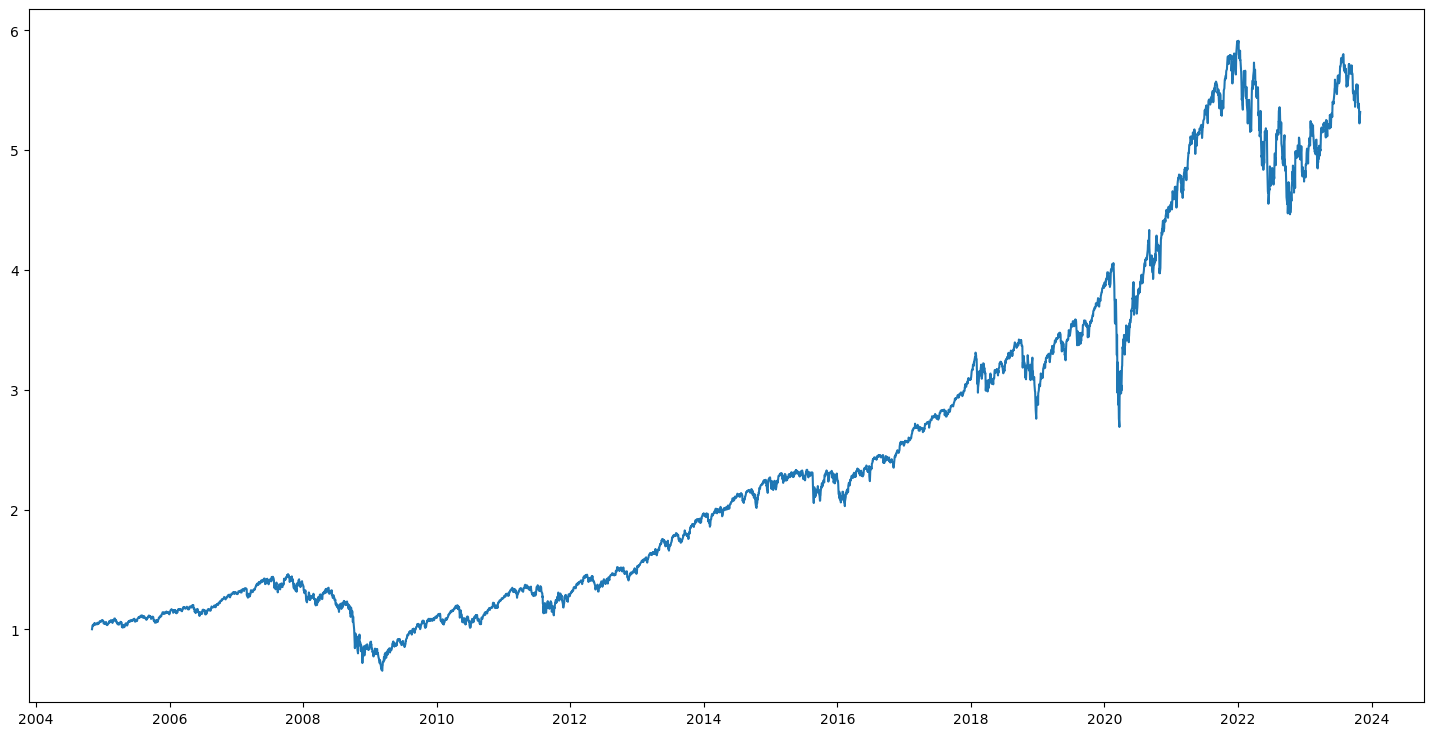

In [5]:
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.show()

In [6]:
#df column calld "str_return"
def cal_sharpe(stock):
    Sharpe =\
    (
        np.sqrt(253) * (stock["str_return"].mean() / stock["str_return"].std()
                        )
    )

    return Sharpe

In [7]:
#df with colum called "cul_return", index date
def cal_CAGR(stock):
    days =\
    (    (stock.index[-1] - stock.index[0])
         .days
    )

    CAGR =\
    (
        (
          (
            (stock["cul_return"][-1]) / 1
          )
            **(365.0/days) 
        ) 
        - 1
    )

    return CAGR

In [8]:
def cal_max_drawdown(stock1):
    stock = stock1.copy()
    
    stock["max_performance"] = stock["cul_return"].cummax()
    stock["drawdown"] = 1 - stock["cul_return"]/stock["max_performance"]
    max_drawdown = stock["drawdown"].max()
    return max_drawdown

In [9]:
def cal_metrics(stock):
    return pd.Series({"sharpe_ratio": cal_sharpe(stock), "CAGR": cal_CAGR(stock), "max_drawdown":cal_max_drawdown(stock)})

In [10]:
cal_metrics(spy1)

sharpe_ratio    0.554122
CAGR            0.091910
max_drawdown    0.551894
dtype: float64

# 2.strategy

## 2.1.RSI

In [11]:
#stock here must be a df with one column called "Adj Close"
def cal_RSI(stock1):
    stock = stock1.copy()
    period = 14

    stock["change"] = stock["Adj Close"].diff()

    stock["gain"] = stock["change"].apply(lambda x: x if x > 0 else 0)
    stock["loss"] = stock["change"].apply(lambda x: -x if x < 0 else 0)

    stock["avg_gain"] = stock["gain"].rolling(period).mean()
    stock["avg_loss"] = stock["loss"].rolling(period).mean()

    for i in range(14,len(stock)):
        stock.iloc[i,4] = (stock.iloc[i-1]["avg_gain"]*13+stock.iloc[i]["gain"])/14
        stock.iloc[i,5] = (stock.iloc[i-1]["avg_loss"]*13+stock.iloc[i]["loss"])/14

    stock["RS"] = stock["avg_gain"]/stock["avg_loss"]
    stock["RSI"] = 100 - 100/(1+stock["RS"])
    
    return stock["RSI"]

In [12]:
#here stock need to be a df with one column named "RSI"
def set_RSI_position(stock1):
    stock = stock1.copy()
    #set RSI_position

    stock["RSI_position"] = np.where(((stock["RSI"]-70)*(stock["RSI"].shift(1)-70)<0)&(stock["RSI"]<70), -1, np.nan)

    #alorithm impovement seems not to imporve....
#     stock["RSI_position"] = np.where(((stock["RSI"]-70)*(stock["RSI"].shift(1)-70)<0)&(stock["RSI"]>70), 0, stock["RSI_position"])
#     stock["RSI_position"] = np.where(((stock["RSI"]-30)*(stock["RSI"].shift(1)-30)<0)&(stock["RSI"]<30), 0, stock["RSI_position"])

    stock["RSI_position"] = np.where(((stock["RSI"]-30)*(stock["RSI"].shift(1)-30)<0)&(stock["RSI"]>30), 1, stock["RSI_position"])
    stock["RSI_position"] = np.where(((stock["RSI"]-50)*(stock["RSI"].shift(1)-50)<0), 0, stock["RSI_position"])
    stock["RSI_position"] = stock["RSI_position"].ffill()
    stock["RSI_position"] = stock["RSI_position"].fillna(0)

    #we need to shift our RSI_position downward cuz we open RSI_position in close price
    stock["RSI_position"] = stock["RSI_position"].shift(1)
    stock["RSI_position"] = stock["RSI_position"].fillna(0)
    return stock["RSI_position"]

## 2.2.MACD

In [13]:
#here we need stock with column with "Adj Close"
def set_MACD_position(stock1, short, long, signal):
    stock = stock1.copy()
    #short and long EWM
#     short_EWM = 12
#     long_EWM = 26
    short_EWM = short
    long_EWM = long

    stock["short_EWM"] = stock["Adj Close"].ewm(span=short_EWM).mean()
    stock["long_EWM"] = stock["Adj Close"].ewm(span=long_EWM).mean()

    #MACD and MACD signal line
    #signal = 9

    stock["MACD"] = stock["short_EWM"] - stock["long_EWM"]
    stock["MACD_signal"] = stock["MACD"].ewm(span = signal).mean()

    stock["MACD_position"] = np.where(stock["MACD"] > stock["MACD_signal"], 1, -1)
    return stock["MACD_position"]

## 2.3.Bollinger Bands

In [14]:
def set_BB_position(stock1, period, multiplier):
    stock = stock1.copy()
    
    stock[f"SMA_{period}"] = stock["Adj Close"].rolling(period).mean()
    stock["upper_threshold"] = multiplier*stock["Adj Close"].rolling(period).std() + stock["Adj Close"]
    stock["lower_threshold"] = -multiplier*stock["Adj Close"].rolling(period).std() + stock["Adj Close"]

    distance = stock["Adj Close"] - stock[f"SMA_{period}"]
    stock["BB_position"] = np.where(stock[f"SMA_{period}"] > stock["upper_threshold"], -1, np.nan)
    stock["BB_position"] = np.where(stock[f"SMA_{period}"] < stock["lower_threshold"], 1, stock["BB_position"])
    stock["BB_position"] = np.where(distance*distance.shift(1) < 0, 0, stock["BB_position"])
    stock["BB_position"].ffill(inplace = True)
    stock["BB_position"] = stock["BB_position"].fillna(0)
    
    return stock["BB_position"]

## 2.4. Simple Momentum

In [15]:
def set_SM_position(stock1):
    stock = stock1.copy()
    
    short = 20
    long = 60

    stock["long_SMA"] = stock["Adj Close"].rolling(long).mean()
    stock["short_SMA"] = stock["Adj Close"].rolling(short).mean()


    stock["SM_position"] = np.where(stock["short_SMA"]>stock["long_SMA"], 1, -1)
    stock["SM_position"][:long] = 0
    return stock["SM_position"]

# 3. Combined Strategy

## 3.1. Bollinger Bands&MACD

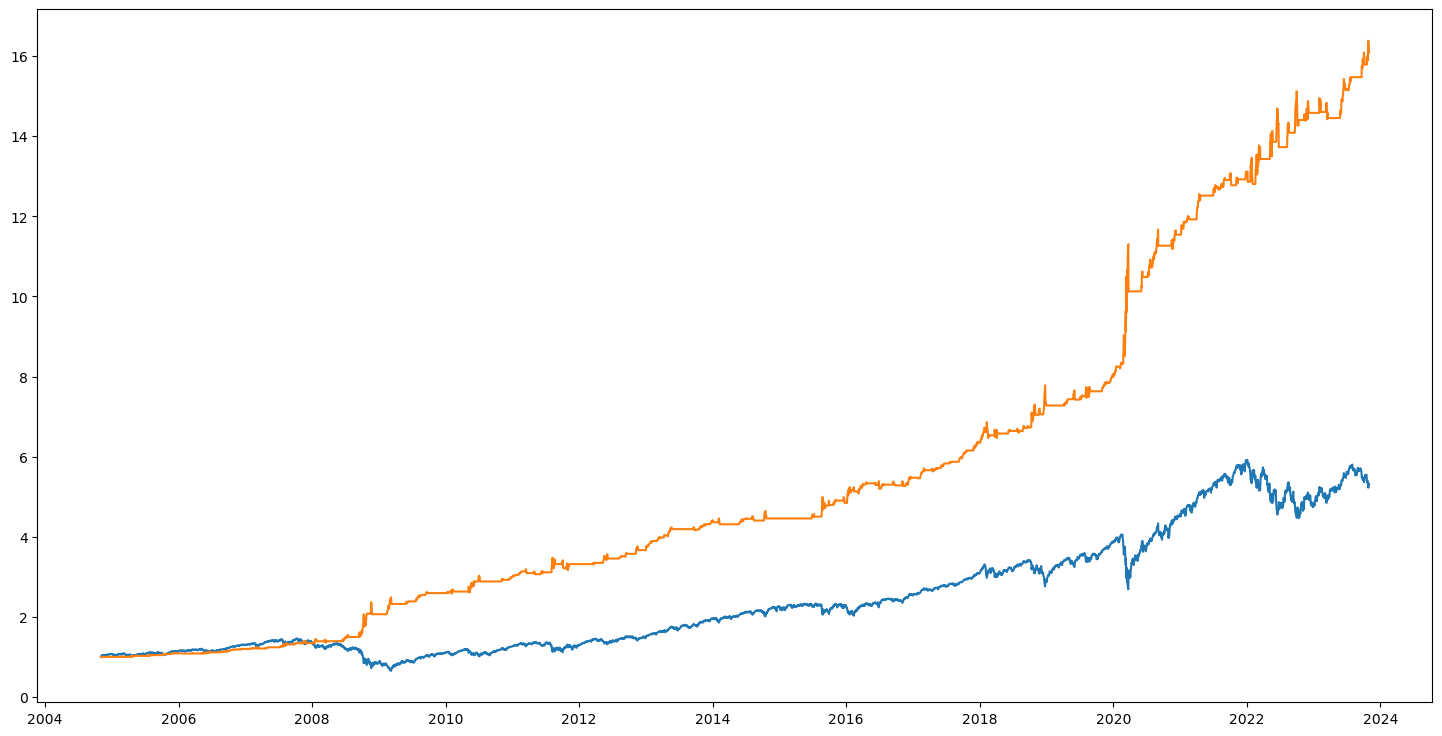

In [16]:
spy2 = spy[["Adj Close"]]

spy2["BB_position"] = set_BB_position(spy2, 42, 2)
spy2["MACD_position"] = set_MACD_position(spy2, 12, 26, 9)

spy2["position"] = np.where((spy2["BB_position"])==(spy2["MACD_position"]), spy2["BB_position"], 0)
spy2 = cal_str_cul_return(spy2)
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.plot(spy2["cul_return"])
plt.show()

## 3.2. Bollinger Bands&Simple Momuntum

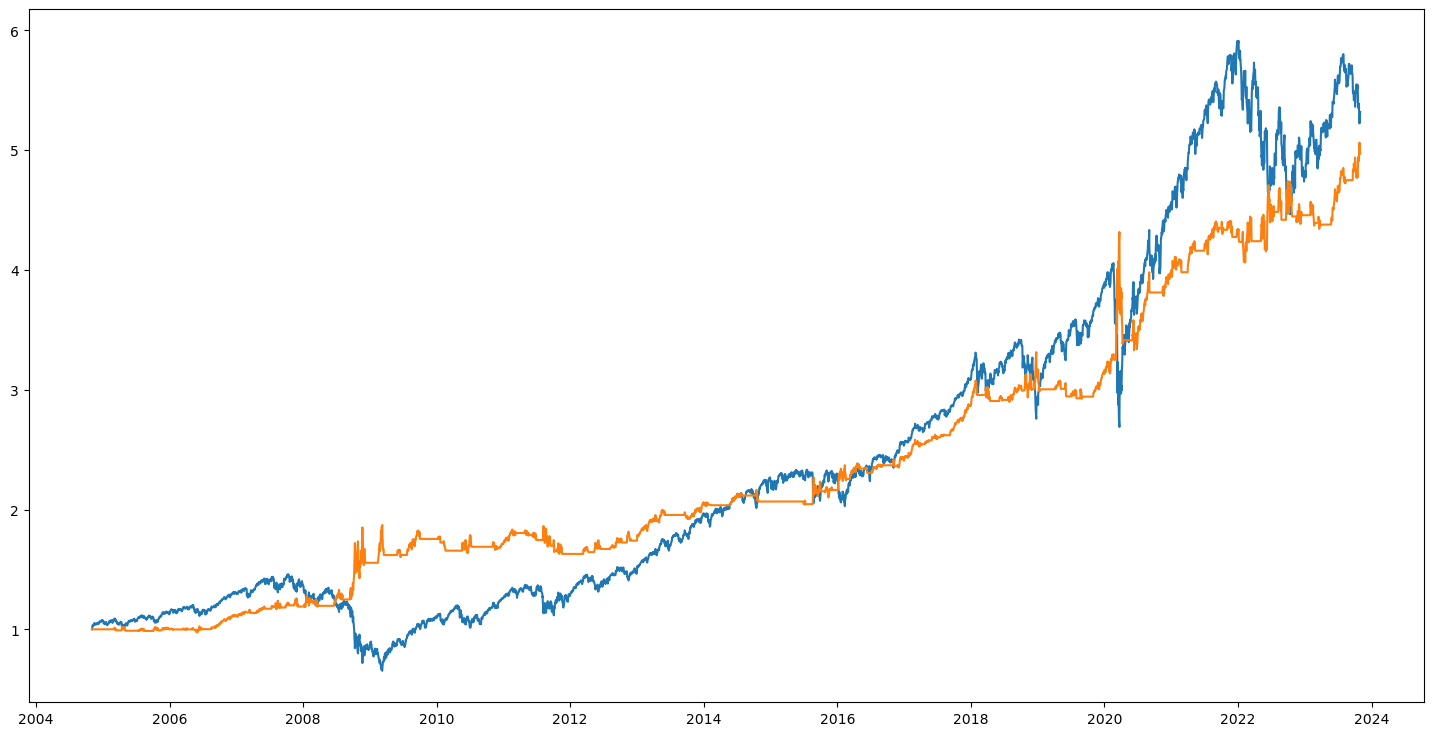

In [17]:
spy3 = spy[["Adj Close"]]

spy3["BB_position"] = set_BB_position(spy3, 42, 2)
spy3["SM_position"] = set_SM_position(spy3)

spy3["position"] = np.where((spy3["BB_position"])==(spy3["SM_position"]), spy3["BB_position"], 0)
spy3 = cal_str_cul_return(spy3)
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.plot(spy3["cul_return"])
plt.show()

## 3.3. RSI&Simple Momuntum

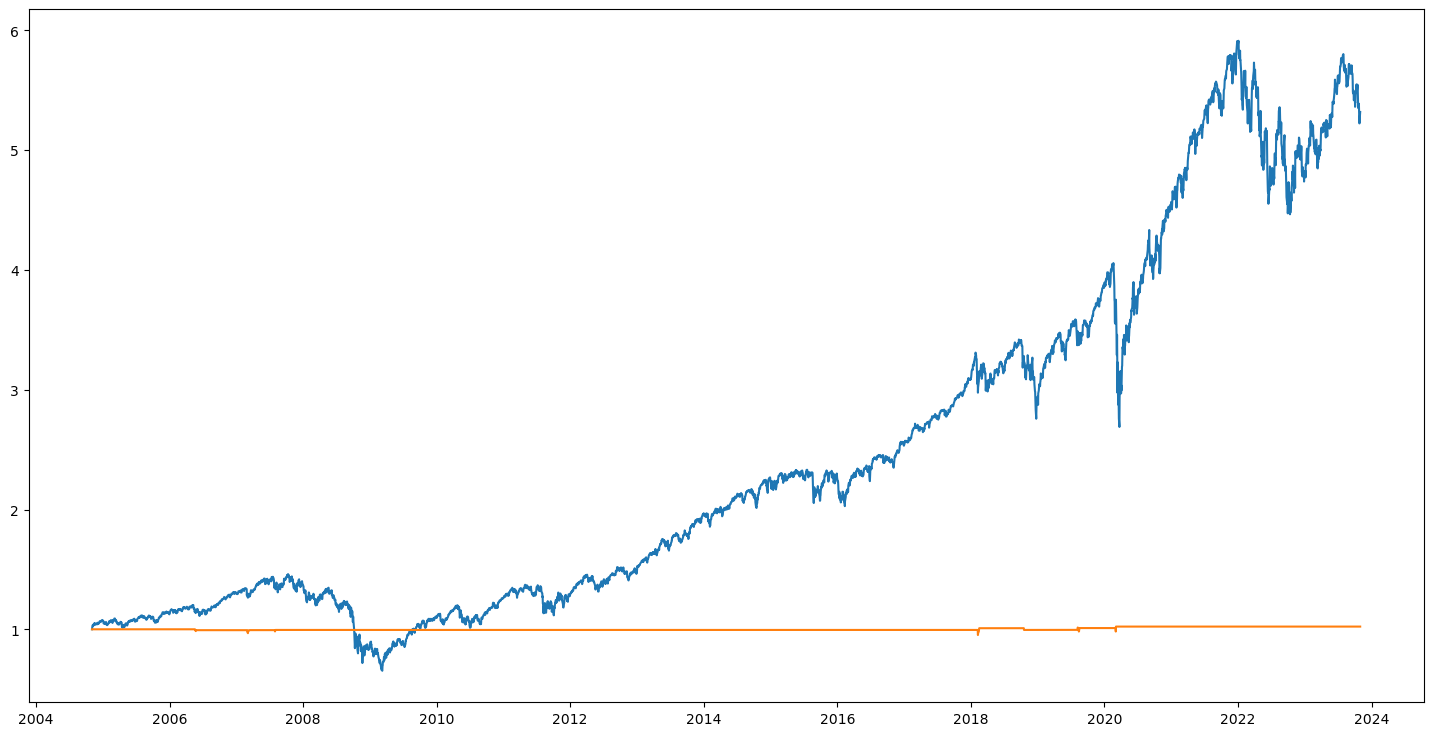

In [18]:
spy4 = spy[["Adj Close"]]

spy4["RSI"] = cal_RSI(spy4)
spy4["RSI_position"] = set_RSI_position(spy4)
spy4["SM_position"] = set_SM_position(spy4)

spy4["position"] = np.where((spy4["RSI_position"])==(spy4["SM_position"]), spy4["RSI_position"], 0)
spy4 = cal_str_cul_return(spy4)
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.plot(spy4["cul_return"])
plt.show()

## 3.4. RSI&MACD

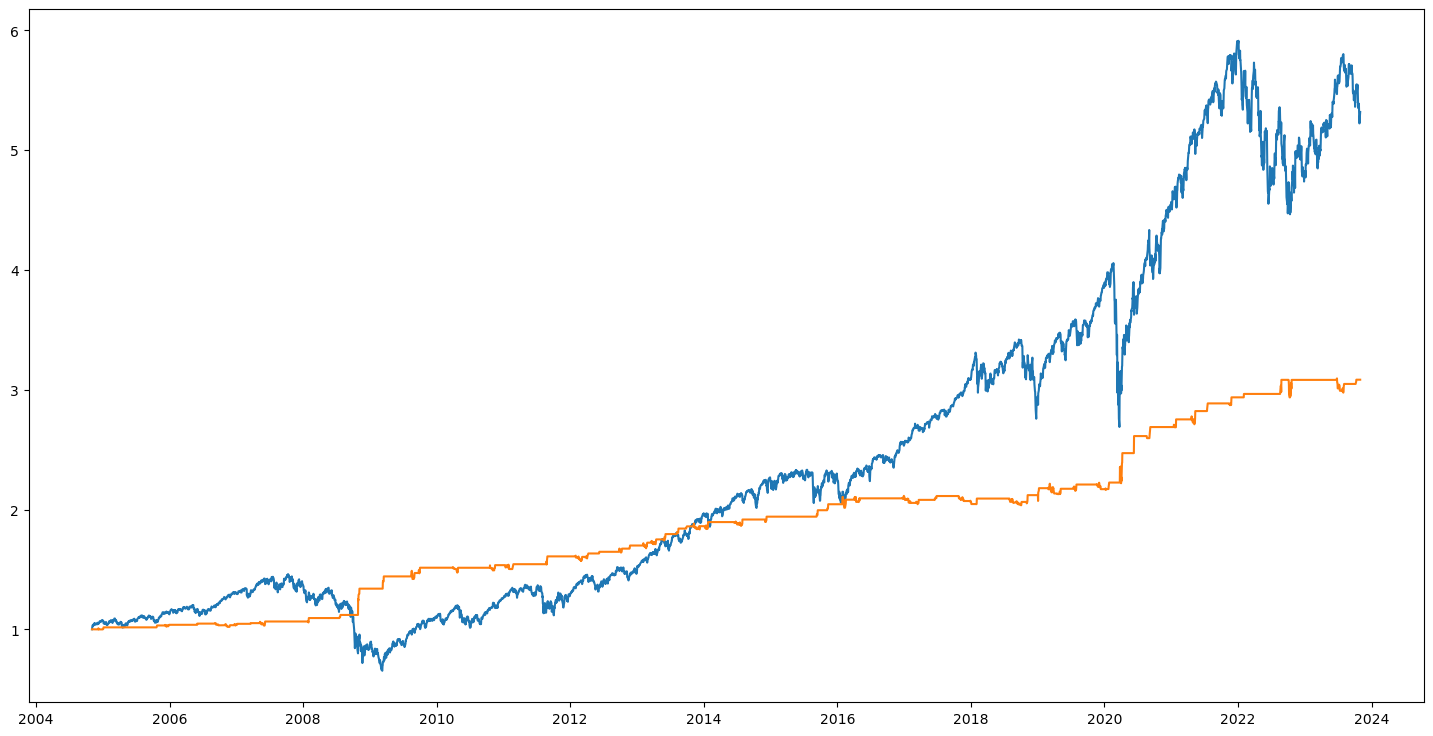

In [19]:
spy5 = spy[["Adj Close"]]

spy5["RSI"] = cal_RSI(spy5)
spy5["RSI_position"] = set_RSI_position(spy5)
spy5["MACD_position"] = set_MACD_position(spy5, 12, 26, 9)

spy5["position"] = np.where((spy5["MACD_position"])==(spy5["RSI_position"]), spy5["MACD_position"], 0)
spy5 = cal_str_cul_return(spy5)
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.plot(spy5["cul_return"])
plt.show()

In [20]:
(
    pd.DataFrame([
        cal_metrics(spy1),
        cal_metrics(spy2),
        cal_metrics(spy3),
        cal_metrics(spy4),
        cal_metrics(spy5)
    ], 
        index=["baseline",
               "BB+MACD", 
               "BB+SM",
               "RSI+SM", 
               "RSI+MACD"]
    )
)

,sharpe_ratio,CAGR,max_drawdown
baseline,0.554122,0.091910,0.551894
BB+MACD,1.184100,0.157365,0.145198
BB+SM,0.634427,0.088026,0.228599
RSI+SM,0.067364,0.001176,0.047911
RSI+MACD,0.975476,0.061040,0.059239


# 4.Parameters Tuning

In [21]:
def assess_BB_MACD_Str(stock1, BB_period, BB_multiplier, MACD_short, MACD_long, MACD_signal):
    stock = stock1.copy()
    
    stock["BB_position"] = set_BB_position(stock, BB_period, BB_multiplier)
    stock["MACD_position"] = set_MACD_position(stock, MACD_short, MACD_long, MACD_signal)
    stock["position"] = np.where((stock["BB_position"])==(stock["MACD_position"]), stock["BB_position"], 0)
    
    final_return = cal_str_cul_return(stock)["cul_return"][-1]
    
    return final_return

In [22]:
def tuning_BB_MACD_paras(stock1, BB_periods, BB_multipliers, MACD_shorts, MACD_longs, MACD_signals):
    stock = stock1.copy()
    
    best_result = 0
    for BB_period in BB_periods:
        for BB_multiplier in BB_multipliers:
            for MACD_short in MACD_shorts:
                for MACD_long in MACD_longs:
                    for MACD_signal in MACD_signals:
                        try:
                            cul_return = assess_BB_MACD_Str(stock, BB_period, BB_multiplier, MACD_short, MACD_long, MACD_signal)
                            if cul_return > best_result:
                                best_result = cul_return
                                parameters = (BB_period, BB_multiplier, MACD_short, MACD_long, MACD_signal)
                        except:
                            continue
    return parameters, best_result 

In [23]:
BB_periods = [5,10,20,30,60]
BB_multipliers = [1,2,3]
MACD_shorts = [5,10]
MACD_longs = [20,30,60]
MACD_signals = range(5, 10)

In [24]:
tuning_BB_MACD_paras(spy2, BB_periods, BB_multipliers, MACD_shorts, MACD_longs, MACD_signals)

((5, 1, 5, 20, 5), 401938.11983495933)

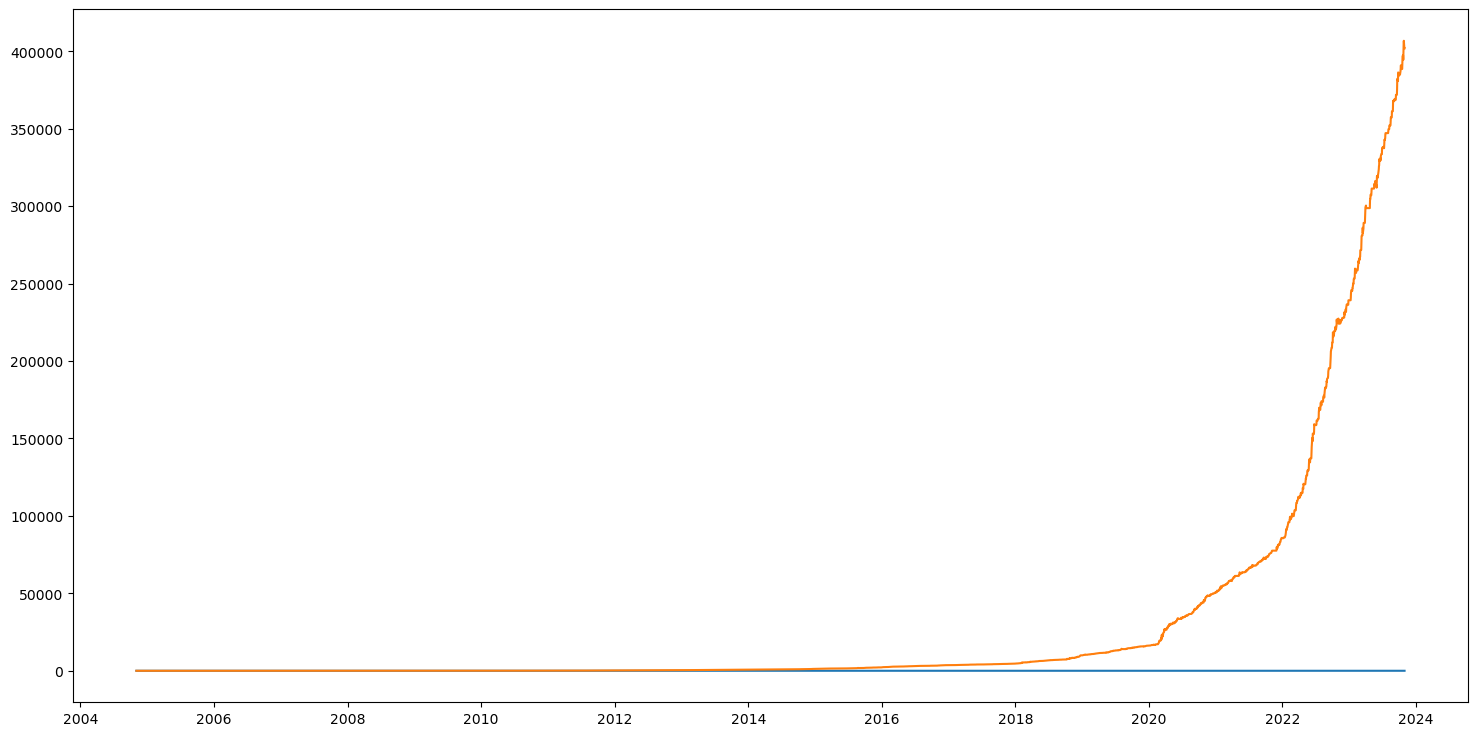

In [25]:
spy6 = spy[["Adj Close"]]

spy6["BB_position"] = set_BB_position(spy6, 5, 1)
spy6["MACD_position"] = set_MACD_position(spy6, 5, 20, 5)

spy6["position"] = np.where((spy6["BB_position"])==(spy6["MACD_position"]), spy6["BB_position"], 0)
spy6 = cal_str_cul_return(spy6)
plt.figure(figsize=[18,9])
plt.plot(spy1["cul_return"])
plt.plot(spy6["cul_return"])
plt.show()

In [26]:
(
    pd.DataFrame([
        cal_metrics(spy1),
        cal_metrics(spy2),
        cal_metrics(spy3),
        cal_metrics(spy4),
        cal_metrics(spy5),
        cal_metrics(spy6)
    ], 
        index=["baseline",
               "BB+MACD", 
               "BB+SM",
               "RSI+SM", 
               "RSI+MACD",
              "BB_MACD tuned"]
    )
)

,sharpe_ratio,CAGR,max_drawdown
baseline,0.554122,0.091910,0.551894
BB+MACD,1.184100,0.157365,0.145198
BB+SM,0.634427,0.088026,0.228599
RSI+SM,0.067364,0.001176,0.047911
RSI+MACD,0.975476,0.061040,0.059239
BB_MACD tuned,5.483616,0.971643,0.085486
